<a href="https://www.kaggle.com/code/tornikeonoprishvili/fdtd-oblique-source-simulation-meep?scriptVersionId=98774224" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!conda install -y -c conda-forge pymeep pymeep-extras seaborn

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pymeep
    - pymeep-extras
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aom-3.3.0                  |       h27087fc_1         2.6 MB  conda-forge
    autograd-1.3               |             py_0          39 KB  conda-forge
    ca-certificates-2022.6.15  |       ha878542_0         149 KB  conda-forge
    cached-property-1.5.2      |       hd8ed1ab_1           4 KB  conda-forge
    cached_property-1.5.2      |     pyha770c72_1          11 KB  conda-forge
    certifi-2022.6.15          |   py37h89c1867_0         155 KB  conda-forge
    conda-4.13.0               |   py37h89c1867_1         989 KB  conda-forge
    ffmpeg-5.0.1               |       h594f047_0        10.1 MB  conda-forge
    future-0.18.2              |   py37h89c1867_5         713 KB  conda-for

# Briefing

End goal is to simulate the following structure, with linear and non-linear materials:

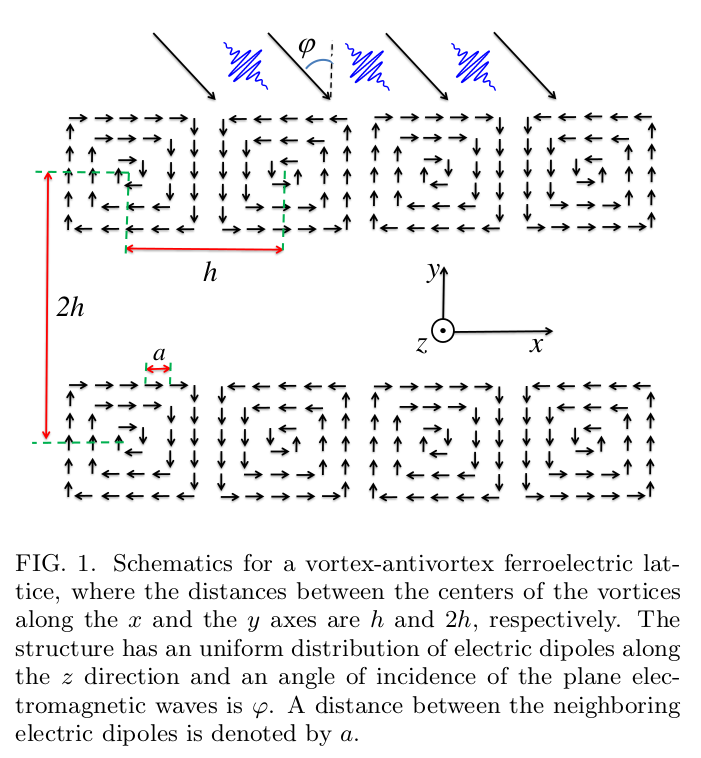

Based on this [article](https://www.nature.com/articles/nature16463)

Our job, specifically, is to **replicate** the already existing results of of FDFD simulations, using FDTD.  

For FDTD, we need to know material's physical properties to simulate it. Most simulations would be about **whether or not a wave of a given frequency passes the through the above structure**. 

This is a 2D simulation. The response to the two polarizations, is different. $E_z$ polarization is unaffected by the dipole directions from Fig. 1. So, for $E_z$, we will have uniform material blocks of size $h \times h$. For $H_z$, each of the $6 \times 6$ mini blocks will have different material, depending on their **rotation with respect to the x-axis**. There is no dispersion in either case. Yet.

In $H_z$, the material epsilon is a following diagonal matrix (Note that $\phi$ in this case is w.r.t. the x-axis, not incoming wave, as shown in Fig 1.

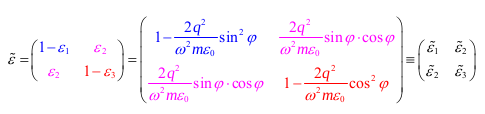

We need concrete numbers, so we substitute the $\hat\epsilon_{00}$ and $\hat\epsilon_{11}$ with $ \epsilon = 1 - 0.01 (\frac{h}{\lambda})^{-2} \cdot A$ where $A$ is $\sin^2(\phi)$ for $\hat\epsilon_{00}$ and $\cos^2(\phi)$ for $\hat\epsilon_{11}$  (off-diagonal members and are just zero and $\hat\epsilon_{33}$ is just 1). So, there is our concrete epsilon there. We just need to specify the $h$ and $\lambda$. 



In $E_z$, the material epsilon is given as $ \epsilon = 1 - 0.01 (\frac{h}{\lambda})^{-2} $ - Notice that whenever $h / \lambda < 0.1$, the $\epsilon$ will be **negative**. [The meep library doesn't support negative epsilon simulations, unless there is dispersion](https://meep.readthedocs.io/en/latest/FAQ/#why-does-my-simulation-diverge-if-the-permittivity-is-less-than-0).



In [3]:
%load_ext autoreload
%autoreload 2

import meep as mp
from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math 
import seaborn as sns
from itertools import product
from math import pi
from functools import partial
import os
import copy
import time
from IPython.display import Video, display

print(mpl.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.5.2


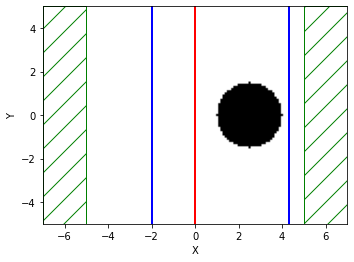

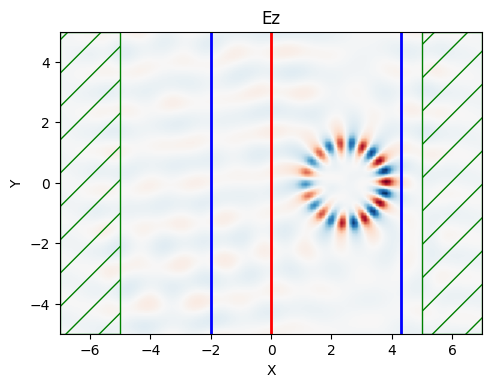

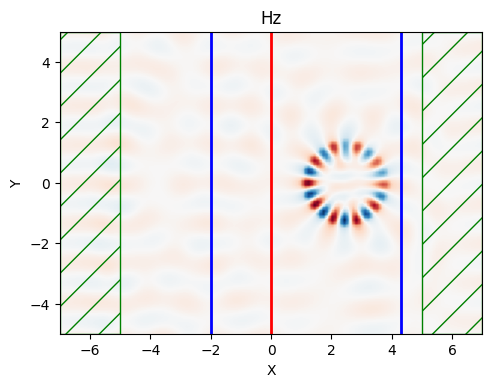

In [22]:
mp.verbosity(0)
rot_angle = 45
# def run_sim(rot_angle = 0):

resolution = 10 # pixels/μm

cell_size = mp.Vector3(14,10,0)
W,H,_ = cell_size

pml_layers = [mp.PML(thickness=2,direction=mp.X) ]

fsrc = 0.5 # frequency of planewave (wavelength = 1/fsrc)
fcen = fsrc
df = 0.1

n = 1.5 # refractive index of homogeneous material
default_material = mp.Medium(index=n)

k_point = mp.Vector3(fsrc*n).rotate(mp.Vector3(z=1), rot_angle)

sources = [mp.EigenModeSource(#src=mp.ContinuousSource(fsrc),
    src=mp.GaussianSource(fcen, fwidth=df),
                              center=mp.Vector3(),
                              size=mp.Vector3(y=10),
                              direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
                              eig_kpoint=k_point,
                              eig_band=1,
#                                   eig_parity=mp.EVEN_Y+mp.ODD_Z if rot_angle == 0 else mp.ODD_Z,
#                                   eig_parity=mp.EVEN_Y+mp.ODD_Z if rot_angle == 0 else mp.EVEN_Z,
                              eig_parity=mp.NO_PARITY,
                              eig_match_freq=True)]
geom = [
    mp.Cylinder(
        radius=1.5,#=mp.Vector3(2,2),
        center=mp.Vector3(2.5,0),
        material=mp.Medium(index=3)
    )
]
sim = mp.Simulation(cell_size=cell_size,
                    resolution=resolution,
                    boundary_layers=pml_layers,
                    sources=sources,
                    k_point=k_point,
                    geometry=geom,
                    default_material=default_material,
                    symmetries=[mp.Mirror(mp.Y)] if rot_angle == 0 else []
                   )

nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(center=mp.Vector3(-2,0,0), size=mp.Vector3(0,W,0))                            
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(center=mp.Vector3(4.3,0,0), size=mp.Vector3(0,W,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

sim.plot2D()

f = plt.figure()
anim = mp.Animate2D(sim, 
                    fields=mp.Ez,
                    f=f, realtime=False, 
                    normalize=True)
plt.close()

f = plt.figure()
anim_hz = mp.Animate2D(sim, 
                    fields=mp.Hz,
                    f=f, realtime=False, 
                    normalize=True)
plt.close()

pt = mp.Vector3(4.2,0,0)
sim.run(mp.at_every(10, anim), 
        mp.at_every(10, anim_hz), 
#         until=40
        until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3),
#         until=1000,
       )

os.makedirs('media/',exist_ok=True)
filename = f"media/anim.mp4"
anim.to_mp4(10,filename)


filename_hz = f"media/anim_hz.mp4"
anim_hz.to_mp4(10,filename_hz)

plt.figure(dpi=100)
plt.title('Ez')
sim.plot2D(fields=mp.Ez)
plt.show()

plt.figure(dpi=100)
plt.title('Hz')
sim.plot2D(fields=mp.Hz)
plt.show()

Video("media/anim.mp4")
# return locals()

In [24]:
straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)
flux_freqs = mp.get_flux_freqs(refl)

In [30]:
straight_tran_flux[0]

0.013332005948378436

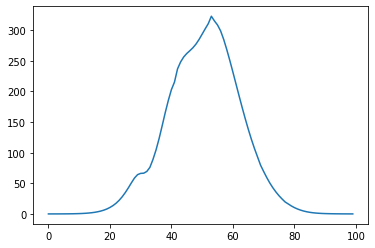

In [34]:
plt.plot(straight_tran_flux)

In [42]:
stra

56800

ValueError: x and y must have same first dimension, but have shapes (100,) and (5050,)

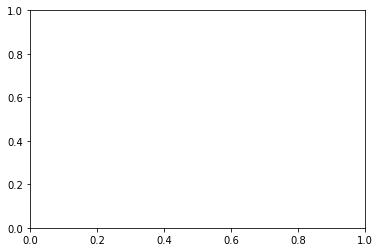

In [43]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])
#     Rs = np.append(Rs,-bend_refl_flux[i]/straight_tran_flux[i])
#     Ts = np.append(Ts,bend_tran_flux[i]/straight_tran_flux[i])    
#     Rs = np.append(Rs,-bend_refl_flux[i]/straight_tran_flux[i])
#     Ts = np.append(Ts,bend_tran_flux[i]/straight_tran_flux[i])    
    Ts = np.append(Ts, straight_tran_flux[i])
    Rs = np.append(Rs, 1-Ts)
    

if mp.am_master():
    plt.figure()
    plt.plot(wl,Rs,'bo-',label='reflectance')
    plt.plot(wl,Ts,'ro-',label='transmittance')
    plt.plot(wl,1-Rs-Ts,'go-',label='loss')
    plt.axis([5.0, 10.0, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.00011301 s
Working in 2D dimensions.
Computational cell is 14 x 10 x 0 with resolution 25
     cylinder, center = (2.5,0,0)
          radius 1.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (9,9,9)
time for set_epsilon = 0.170184 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(0.979055,0.482091,0) = 0.5 after 31 iters


FloatProgress(value=0.0, description='0% done ', max=40.0)

     cylinder, center = (2.5,0,0)
          radius 1.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (9,9,9)
     cylinder, center = (2.5,0,0)
          radius 1.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (9,9,9)
Meep progress: 22.82/40.0 = 57.0% done in 4.0s, 3.0s to go
on time step 1143 (time=22.86), 0.00350024 s/step
Normalizing field data...
Normalizing field data...
run 0 finished at t = 40.0 (2000 timesteps)
Generating MP4...
Generating MP4...
     cylinder, center = (2.5,0,0)
          radius 1.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (9,9,9)


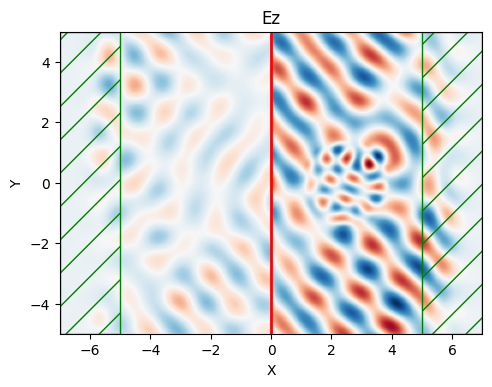

     cylinder, center = (2.5,0,0)
          radius 1.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (9,9,9)


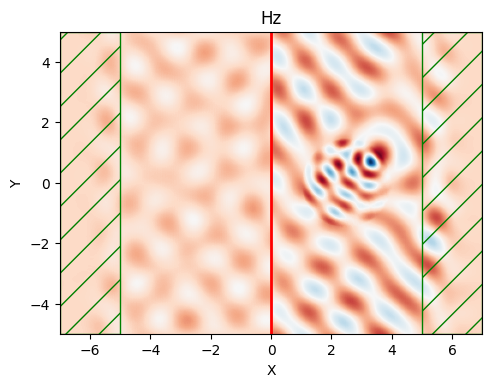

In [4]:
# Do simple a reference simulation for oblique source
for rot_angle in np.radians([40]):
    res = run_sim(rot_angle)
Video("media/anim.mp4")

In [5]:
Video("media/anim_hz.mp4")

Note that this example involves a ContinuousSource for the time profile. For a pulsed source, the oblique planewave is incident at a given angle for only a single frequency component of the source. This is a fundamental feature of FDTD simulations and not of Meep per se. Thus, to simulate an incident planewave at multiple angles for a given frequency ω, you will need to do separate simulations involving different values of k⃗  (k_point) since each set of (k⃗ ,ω) specifying the Bloch-periodic boundaries and the frequency of the source will produce a different angle of the planewave. For more details, refer to Section 4.5 ("Efficient Frequency-Angle Coverage") in Chapter 4 ("Electromagnetic Wave Source Conditions") of Advances in FDTD Computational Electrodynamics: Photonics and Nanotechnology.

## Fields in a waveguide

In [16]:
def simulate(ratio = 0.21, 
             n_slabs = 24, 
             polarization = mp.Ez,
             vortex = False, 
             empty_sim = False,
             rot_angle = 0,
             animate = False,
             squeeze_x = True,
             space_resolution_multiplier=1,
             time_resolution_multiplier=1,
             refl_trans_space = False,
            ):
    rot_angle = np.radians(rot_angle)
    call_args = {k:v for k,v in locals().items()}

    vortex_rows = n_slabs * 2
    if squeeze_x: 
        vortex_cols = 2 # Only works for eigenmode source
    else:
        vortex_cols = min(9,(vortex_rows // 3)) 

    # unit scale of simulation is h * 1.0
    h = 1 # nanometers
    lamd = h / ratio # nanometers
    k_0 = - 0.01 * ((h/lamd) ** (-2)) # Used for eps hat calculation
    min_eps = 1 + min( +k_0, -k_0 )
    
    if vortex:
        min_px_per_h = 12
    else: 
        min_px_per_h = 6
    
    resolution = math.ceil(max(1 / (lamd / 10), 1 / (h / min_px_per_h)))
    resolution = resolution * space_resolution_multiplier
    size_of_pixel = 1 / resolution

    pml_size = lamd * 0.50
    pml_depth = math.ceil(pml_size) # nm
    if refl_trans_space:
        pml_depth += 10 * h

    simulation_area = np.array([vortex_cols * h, (vortex_rows + 1) * h, 0])
    grid_size = simulation_area + [pml_depth * 0, pml_depth * 2, 0] # nm

    courant_factor = 0.9
    courant = courant_factor * (abs(min_eps) ** .5) / (2 ** .5) / time_resolution_multiplier
    time_resolution = courant_factor * size_of_pixel
    
    # this is pixels per scale (nanometers here). 
    # The vortices have size 10nmx10nm, and consist of 
    # 6x6 cells. So, the resolution should be

    
    cell = mp.Vector3(*grid_size) / 1.
    W,H, _ = grid_size
    D = pml_depth    
    
    
    print(f'Resolution is {resolution} per h, k_0 is {k_0:.5f}, min_eps {min_eps}')    
    print(f'Grid size NU: {cell}, PX: {cell * resolution}')

    
    k_point = mp.Vector3(0,-1/lamd,0).rotate(mp.Vector3(z=1), rot_angle)
    center = mp.Vector3(0, H/2 - D - h * .5, 0)
    sources = [mp.EigenModeSource(src=mp.ContinuousSource(wavelength=lamd),
                #component=polarization, # Needs both components
                size=mp.Vector3(W , 0, 0),
                center=center,
                direction=mp.AUTOMATIC if rot_angle == 0 else mp.NO_DIRECTION,
                eig_kpoint=k_point,
                eig_band=1,
                #               eig_parity=mp.EVEN_Y+mp.ODD_Z if rot_angle == 0 else mp.ODD_Z,
                eig_parity = mp.ODD_Z if polarization == mp.Ez else mp.EVEN_Z,
                eig_match_freq=True)]
    
    pml_layers = [mp.PML(pml_size, direction=mp.Y)]
    
    geometry = []
    
    vortex_rads = np.zeros((6,6))
    d = 3
    for val in [pi * 1.5, pi, pi * .5, 0]:
        for x,y in product(range(6), range(6)):
            if y - d >= abs(x - d): 
                vortex_rads[x,y] = val
        vortex_rads = np.rot90(vortex_rads)
    
    def make_eps_function_at(center, size):
        bins = np.linspace([-size.x/2,-size.y/2],[+size.x/2, +size.y/2],7)
        def eps_function(p):
            x,y = p.x - center.x, p.y - center.y
            x = np.digitize(x,bins[:,0],right=False)
            y = np.digitize(y,bins[:,1],right=False)
            x = np.clip(x, 1, 6) - 1
            y = np.clip(y, 1, 6) - 1
            eps_1 = 1 + k_0 * np.sin(vortex_rads[x,y]) ** 2 # first eps (for Ex)
            eps_3 = 1 + k_0 * np.cos(vortex_rads[x,y]) ** 2 # middle eps (for Ey)
            eps_4 = 1 # last eps (For Ez)
            return mp.Medium(epsilon_diag=(eps_1, eps_3, eps_4))
        return eps_function
    
    if not empty_sim:
        for row in range(vortex_rows):
            for col in range(vortex_cols):
                if row % 2 == 0: # Leave out air between rows
                    size = mp.Vector3(h,h,mp.inf)
                    center = mp.Vector3(
                        x=h / 2 + col * h - W / 2,
                        y=D + h * 1.5 + row * h - H / 2, 
                        z=0
                    )
                    if vortex:
                        material = make_eps_function_at(center, size)
                    else:
                        material = mp.Medium(epsilon=1 + k_0)
                    bl = mp.Block(
                        size=size,
                        center=center,
                        material=material
                    )
                    geometry.append(bl)
    
    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        geometry_center=mp.Vector3(0,0,0),
        sources=sources,
        resolution=resolution,
        Courant=courant,
        k_point=k_point,
    )
    
    sim.init_sim()
    eps_grid = sim.get_epsilon()
    vals = []
    def get_slice(sim):
        vals.append(
            sim.get_array(
                center=mp.Vector3(0,0,0), 
                size=mp.Vector3(0,H,0),
                component=polarization
            )
        )
        
    f = plt.figure(figsize=(20,20))
    anim = mp.Animate2D(sim, 
                        fields=polarization,
                        f=f, 
                        realtime=False, 
                        normalize=True)
    plt.close()
    
    anim_name = ';'.join(list(str(k)+'-'+str(v) for k,v in call_args.items()))
    anim_name += ';'+time.strftime("%Y%m%d-%H%M%S")
    os.makedirs('media/',exist_ok=True)
    anim_filename = f"media/{anim_name}.mp4"
    
    callbacks = [
        mp.at_every(998, get_slice),
    ]

    if animate:
        callbacks.append(mp.at_every(20,anim))
        
    sim.run(
        *callbacks,
        until=1000,
    )
    if animate:
        anim.to_mp4(10,anim_filename)
    
    # Return all local variables
    return locals()

def show_results(res):
    plt.figure(figsize=(20,20))
    plt.subplot(4,4,1)
    print(res['call_args'])
#     plt.title(res['anim_filename'])
    plt.plot(res['vals'][0])
    plt.subplot(4,4,2)
    plt.imshow(res['eps_grid'])
    plt.subplot(4,4,3)
    plt.imshow(res['sim'].get_efield_z().real)
    plt.subplot(4,4,4)
    plt.imshow(res['sim'].get_hfield_z().real)
    display(Video(res['anim_filename']))

mp.verbosity(0)

0

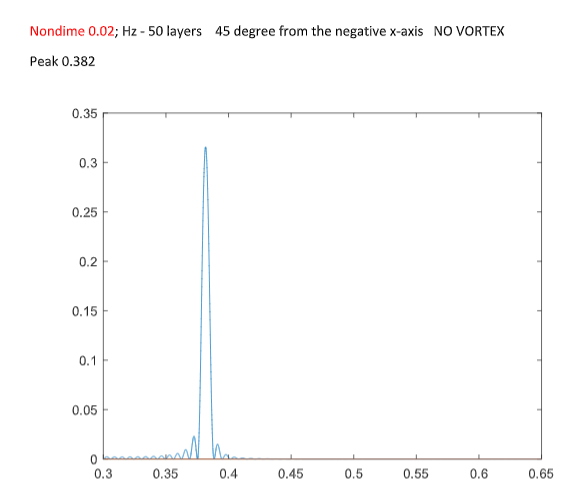

Resolution is 6 per h, k_0 is -0.06853, min_eps 0.9314711767769523
Grid size NU: Vector3<9.0, 125.0, 0.0>, PX: Vector3<54.0, 750.0, 0.0>


100%|██████████| 100/100 [00:00<00:00, 3717.60it/s]
/opt/conda/lib/python3.7/site-packages/meep/simulation.py:2041: RuntimeWarning: Epsilon < 1 may require adjusting the Courant parameter. See the 'Numerical Stability' entry under the 'Materials' section of the documentation
  warnings.warn(eps_warning, RuntimeWarning)


FloatProgress(value=0.0, description='0% done ', max=1000.0)

{'ratio': 0.382, 'n_slabs': 50, 'vortex': False, 'empty_sim': False, 'rot_angle': 0.7853981633974483, 'animate': True, 'squeeze_x': False, 'refl_trans_space': True, 'polarization': 9}


/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


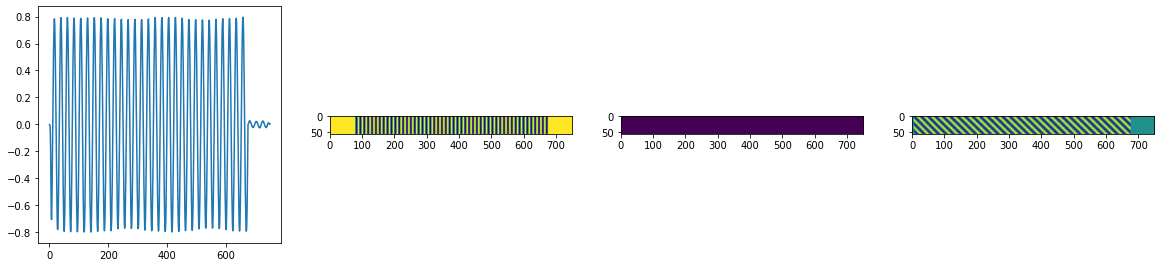

In [8]:
# This has to reflect only a small portion,
# In a mirror-like fashion (+90 deg)
res = simulate(0.382,
               n_slabs=50,
               vortex=False, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=False,
               rot_angle=90 - 45,
               refl_trans_space=True)
show_results(res)

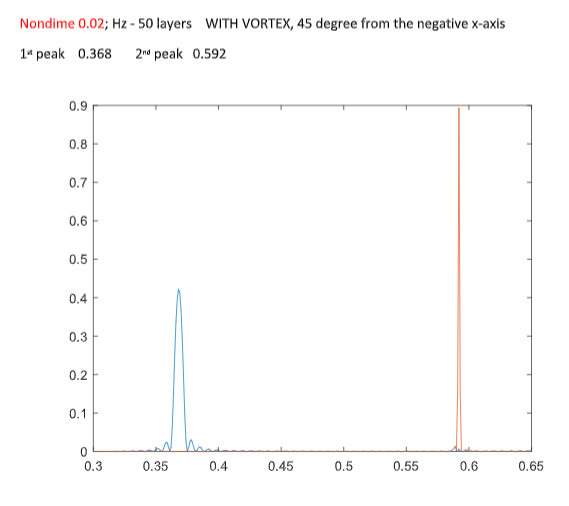

Resolution is 24 per h, k_0 is -0.02853, min_eps 0.9714663988312637
Grid size NU: Vector3<2.0, 123.0, 0.0>, PX: Vector3<48.0, 2952.0, 0.0>


FloatProgress(value=0.0, description='0% done ', max=1000.0)

{'ratio': 0.592, 'n_slabs': 50, 'vortex': True, 'empty_sim': False, 'rot_angle': 0.7853981633974483, 'animate': True, 'squeeze_x': True, 'space_resolution_multiplier': 2, 'time_resolution_multiplier': 2, 'refl_trans_space': True, 'polarization': 9}


/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


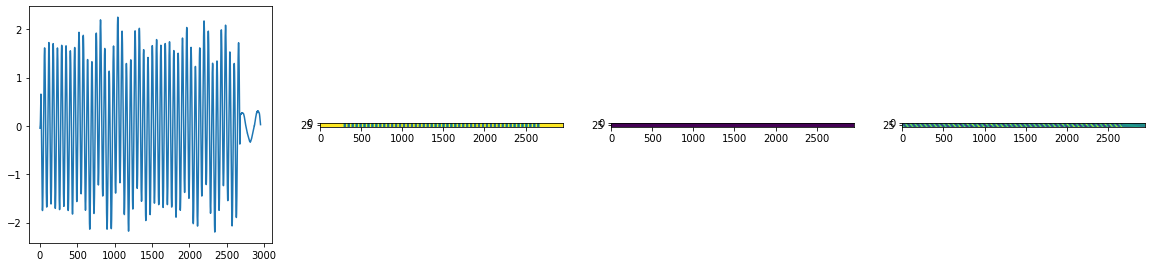

In [17]:
# This has to reflect almost all
# With +180 turn. The waves are reversed.
res = simulate(0.592,
               n_slabs=50,
               vortex=True, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=True,
               rot_angle=90 - 45,
               space_resolution_multiplier=2,
               time_resolution_multiplier=2,
               refl_trans_space=True)
show_results(res)

Resolution is 12 per h, k_0 is -0.07384, min_eps 0.9261578449905482
Grid size NU: Vector3<2.0, 125.0, 0.0>, PX: Vector3<24.0, 1500.0, 0.0>


100%|██████████| 100/100 [00:00<00:00, 9376.31it/s]


FloatProgress(value=0.0, description='0% done ', max=1000.0)

{'ratio': 0.368, 'n_slabs': 50, 'vortex': True, 'empty_sim': False, 'rot_angle': 0.7853981633974483, 'animate': True, 'squeeze_x': True, 'refl_trans_space': True, 'polarization': 9}


/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


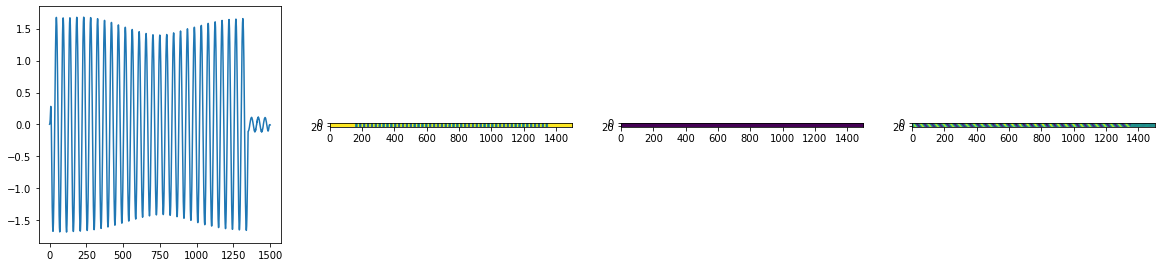

In [9]:
# This has to reflect only a small portion,
# In a mirror-like fashion (+90 deg)
res = simulate(0.368,
               n_slabs=50,
               vortex=True, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=True,
               rot_angle=90 - 45,
               refl_trans_space=True)
show_results(res)

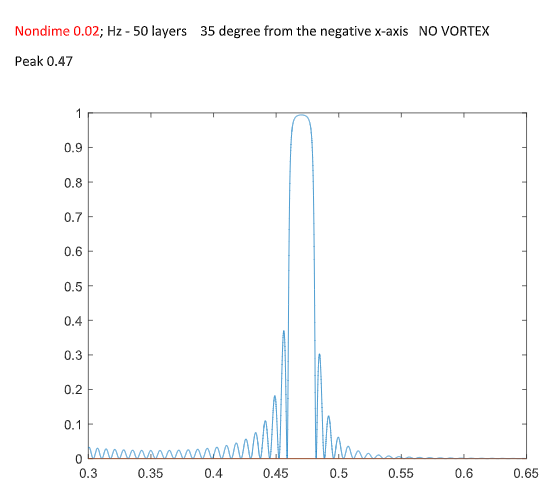

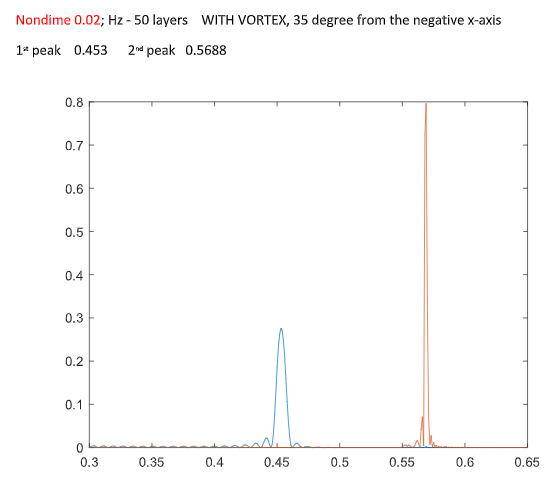

In [ ]:
# This has to pass, no reflections
res = simulate(0.57, 
               n_slabs=50,
               vortex=True, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=True,
               rot_angle=90 - 28,
               refl_trans_space=True)
show_results(res)

In [ ]:
# This has to pass, no reflections
res = simulate(0.555, 
               n_slabs=50,
               vortex=True, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=True,
               rot_angle=90 - 28,
               refl_trans_space=True)
show_results(res)

In [ ]:
# This *has to* partially reflect, opposite direction to the source (+180 deg).
res = simulate(0.561, 
               n_slabs=50,
               vortex=True, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=True,
               rot_angle=90 - 28,
               refl_trans_space=True)
show_results(res)

In [ ]:
# This *has to* reflect, and in the (90 - 28) + 180 degree direction
res = simulate(0.561, # Make sure above and below will pass
               n_slabs=50,
               vortex=False, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=False,
               rot_angle=90 - 28,
               refl_trans_space=True,
              )
show_results(res)

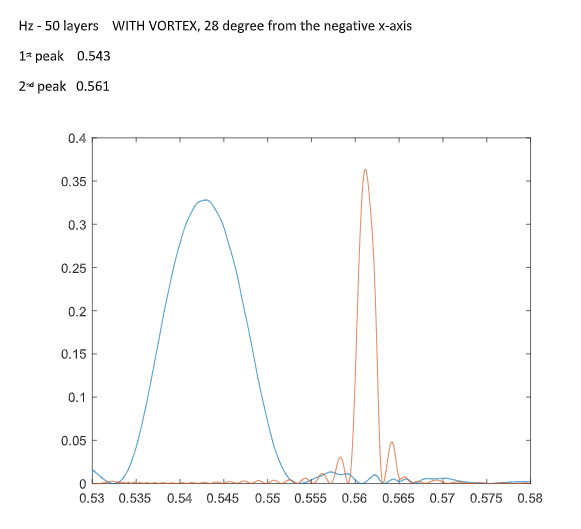

Expected blue line reflection diretion

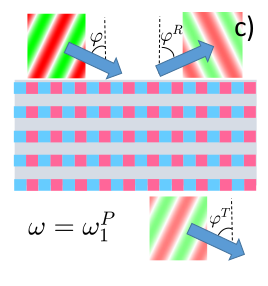

Expected orange line reflection diretion

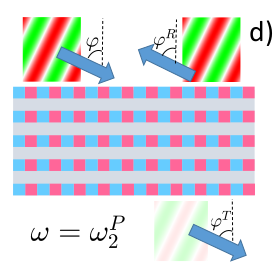

In [ ]:
# This *has to* reflect, and in the (90 - 28) + 180 degree direction
res = simulate(0.5525, # Make sure above and below will pass
               n_slabs=50,
               vortex=False, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=False,
               rot_angle=90 - 28,
               refl_trans_space=True,
              )
show_results(res)

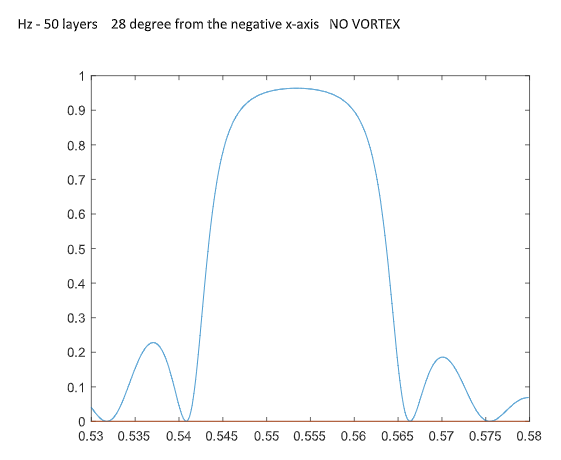

In [ ]:
# This *has to* reflect, if the vortices are drawn correctly
# We don't see that effect here, therefore, vortices aren't correct
res = simulate(0.561, # Make sure above and below will pass
               n_slabs=30,
               vortex=False, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=False,
               rot_angle=90 - 28,
               reflection_space=True,
              )
show_results(res)

In [ ]:
# This *has to* reflect, if the vortices are drawn correctly
# We don't see that effect here, therefore, vortices aren't correct
res = simulate(0.561, # Make sure above and below will pass
               n_slabs=30,
               vortex=True, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=True,
               rot_angle=90 - 28)
show_results(res)

In [ ]:
plt.figure(figsize=(50,50), dpi=200)
plt.imshow(res['sim'].get_epsilon())

In [ ]:
res = simulate(0.561, # Make sure above and below will pass
               n_slabs=60,
               vortex=False, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=True,
               rot_angle=90 - 28)
show_results(res)

In [ ]:
res = simulate(0.541, # Make sure above and below will pass
               n_slabs=60,
               vortex=False, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=False,
               rot_angle=90 - 28)
show_results(res)

In [ ]:
res = simulate(0.26, # Make sure above and below will pass
               vortex=False, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=False,
               rot_angle=0)
show_results(res)

In [ ]:
res = simulate(0.28, # Make sure above and below will pass
               vortex=False, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=False,
               rot_angle=0)
show_results(res)

In [ ]:
res = simulate(0.23, # Make sure above and below will pass
               vortex=False, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=False,
               rot_angle=0)
show_results(res)

In [ ]:
#Simulate Hz polarization
res = simulate(0.367, # Make sure above and below will pass
               #vortex=True, # Vortices are not needed for this effect!
               polarization=mp.Ez, 
               empty_sim=False,
               animate=True,
               squeeze_x=False, rot_angle=45)
show_results(res)

res = simulate(0.367, # Make sure above and below will pass
               #vortex=True, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=False, rot_angle=45)
show_results(res)

In [ ]:
res = simulate(0.12, 
               #vortex=True,
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True, squeeze_x=False, rot_angle=45)
show_results(res)

In [ ]:
res = simulate(0.12, 
               #vortex=True,
               polarization=mp.Hz, 
               empty_sim=True,
               animate=True, squeeze_x=False, rot_angle=45)
show_results(res)

In [ ]:
res = simulate(0.20, 
               #vortex=True,
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True, squeeze_x=False, rot_angle=45)
show_results(res)

In [ ]:
#Simulate Hz polarization
res = simulate(0.26, 
               #vortex=True,
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True, squeeze_x=True, rot_angle=0)
show_results(res)

In [ ]:
#Simulate Hz polarization
res = simulate(0.26, 
               #vortex=True, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=True, # Make sure no struct will pass all.
               animate=True,
               squeeze_x=True, rot_angle=0)
show_results(res)

In [ ]:
#Simulate Hz polarization
res = simulate(0.29, # Make sure above and below will pass
               #vortex=True, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=True, rot_angle=0)
show_results(res)

res = simulate(0.21, # Make sure above and below will pass
               #vortex=True, # Vortices are not needed for this effect!
               polarization=mp.Hz, 
               empty_sim=False,
               animate=True,
               squeeze_x=True, rot_angle=0)
show_results(res)

In [ ]:
# #Simulate Hz polarization
# res = simulate(0.29, # Make sure above and below will pass
#                #vortex=True, # Vortices are not needed for this effect!
#                polarization=mp.Hz, 
#                empty_sim=False,
#                animate=True,
#                squeeze_x=True, rot_angle=0)
# show_results(res)

In [ ]:
# #Simulate Hz polarization
# mp.verbosity(0)
# res = simulate(0.26, #vortex=True,
#                polarization=mp.Ez, #empty_sim=False,
#                animate=True, squeeze_x=True, rot_angle=0)
# # res2 = simulate(0.26, polarization=mp.Hz, empty_sim=True,
# #                animate=True, squeeze_x=False, rot_angle=0)
# plt.plot(res['vals'][0])
# plt.figure()
# plt.imshow(res['eps_grid'])
# Video(res['anim_filename'])

In [ ]:
# plt.plot(res2['vals'][0])
# plt.figure()
# plt.imshow(res['eps_grid'])
# Video(res['anim_filename'])

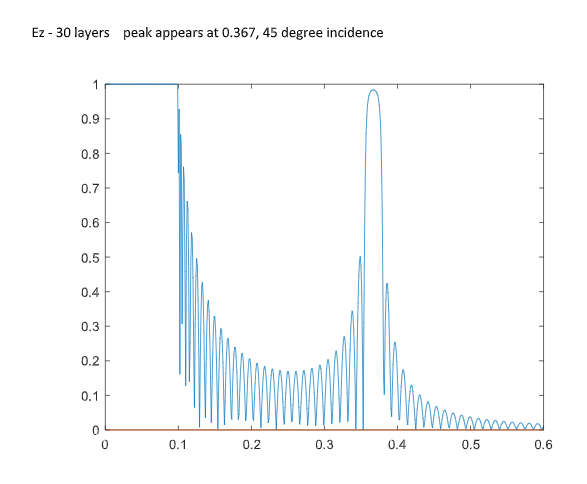

Hz polarization, with 45 degree angle: 

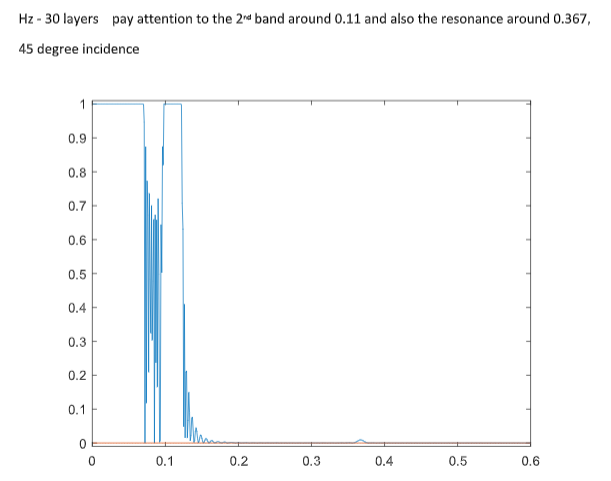



Current tasks: We want to make replicate the already existing  reflection/transmission diagrams. 

Reflection for $H_z$ polarization, this time, we do have vortices within blocks::

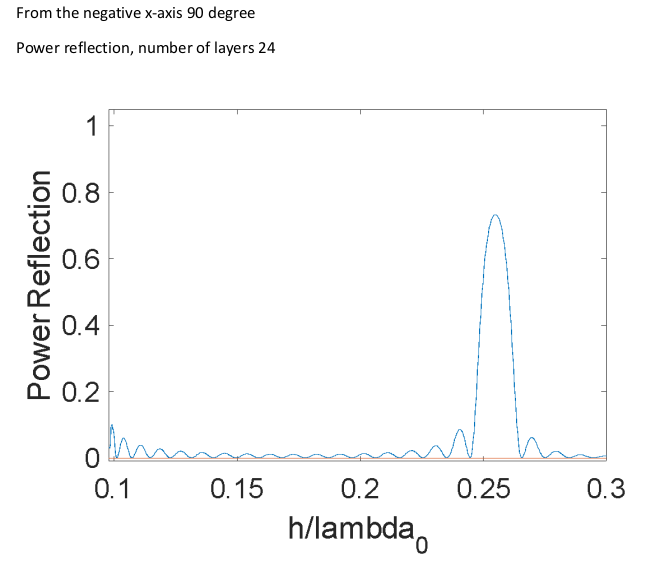

The reflection peak is still expected to be at $h / \lambda = 0.26$.

Replication in progress!

Current tasks: We want to replicate the already existing  reflection/transmission diagrams. 

Reflection for $E_z$ polarization:

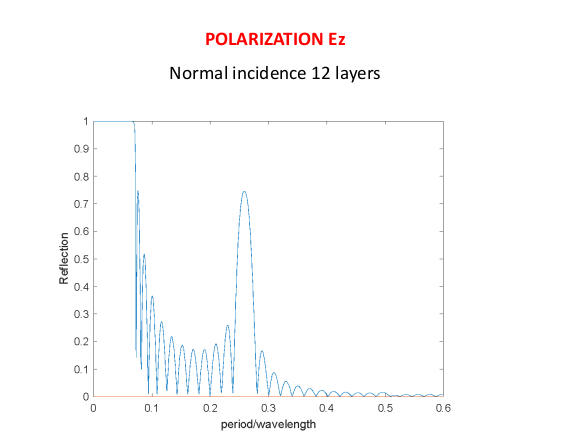

Here, the reflection peak is expected to be at $h / \lambda = 0.26$ 

**This has been replicated!**

In [ ]:
# Simulate Ez polarization
# mp.verbosity(0)

# res = simulate(0.26, empty_sim=False, animate=True, squeeze_x=True, rot_angle=0)
# res2 = simulate(0.26, empty_sim=False, animate=True, squeeze_x=True, rot_angle=0)

# res = simulate(0.30, empty_sim=False, animate=True, squeeze_x=False, rot_angle=45)
# res2 = simulate(0.30, empty_sim=True, animate=True, squeeze_x=False, rot_angle=45)


# res = simulate(0.30, empty_sim=False, animate=True, squeeze_x=False, rot_angle=30)
# res2 = simulate(0.30, empty_sim=True, animate=True, squeeze_x=False, rot_angle=30)

# res = simulate(0.30, empty_sim=True, animate=True, squeeze_x=False, rot_angle=45)
# from IPython.display import Video
# plt.plot(res['vals'][0])
# plt.figure()
# plt.imshow(res['eps_grid'])
# Video(res['anim_filename'])


In [ ]:
# res = simulate(0.30, empty_sim=False, animate=True, squeeze_x=False, rot_angle=30)
# plt.plot(res['vals'][0])
# plt.figure()
# plt.imshow(res['eps_grid'])
# Video(res['anim_filename'])

In [ ]:
# res = simulate(0.36, empty_sim=False, animate=True, squeeze_x=False, rot_angle=30)
# plt.plot(res['vals'][0])
# plt.figure()
# plt.imshow(res['eps_grid'])
# Video(res['anim_filename'])

In [ ]:
# res = simulate(0.25, empty_sim=False, animate=True, squeeze_x=False, rot_angle=30)
# plt.plot(res['vals'][0])
# plt.figure()
# plt.imshow(res['eps_grid'])
# Video(res['anim_filename'])

In [ ]:
# res2 = simulate(0.30, empty_sim=True, animate=True, squeeze_x=False, rot_angle=30)
# plt.plot(res2['vals'][0])
# plt.figure()
# plt.imshow(res2['eps_grid'])
# Video(res2['anim_filename'])

In [ ]:
# res = simulate(0.30, empty_sim=True, animate=True, squeeze_x=False, rot_angle=60)
# plt.plot(res['vals'][0])
# plt.figure()
# plt.imshow(res['eps_grid'])
# Video(res['anim_filename'])

In [ ]:
# from IPython.display import Video
# plt.plot(res['vals'][0])
# plt.figure()
# plt.imshow(res['eps_grid'])
# Video(res['anim_filename'])

In [ ]:
# from IPython.display import Video
# plt.plot(res2['vals'][0])
# plt.figure()
# plt.imshow(res2['eps_grid'])
# Video(res2['anim_filename'])

In [ ]:
# results = {}
# for r in tqdm(np.arange(0.21,0.34,0.01)):
#     for rows in [32]:
#         for empty_sim in [True, False]:
#             results[(r,rows,empty_sim)] = simulate(
#                     ratio = r, 
#                     n_slabs = rows, 
#                     polarization = mp.Ez,
#                     vortex = False, 
#                     empty_sim = empty_sim,
#                     angle_d = 0,
#                 )

In [ ]:
# for (r, rows, empty_sim),result in results.items():
#     if not empty_sim:
#         plt.figure(figsize=(6,2))
#         plt.plot(result['vals'][0])
#         plt.title(f'ratio {r}, rows {rows}, Empty? {empty_sim}')
        


In [ ]:
# for (r, rows, empty_sim),result in results.items():
#     if empty_sim:
#         plt.figure(figsize=(6,2))
#         plt.plot(result['vals'][0])
#         plt.title(f'ratio {r}, rows {rows}, Empty? {empty_sim}')

In [ ]:
# def run_sim(sim, get_slice, anim=False, file_outputs=False):
#     callbacks = []
#     if anim:
#         f = plt.figure()
#         anim = mp.Animate2D(sim, fields=polarization, f=f, realtime=False, normalize=True)
#         plt.close()
#         callbacks.append(mp.at_every(40,anim))
#     if file_outputs:
#         os.makedirs('outputs',exist_ok=True)
#         !rm -rf eps*h5
#         !rm -rf hz.h5
#         callbacks.append( mp.at_beginning(mp.output_epsilon) )
        
#     vals = []
#     callbacks.append(mp.at_every(499,get_slice))
#     sim.run(
#         # mp.to_appended("hz",mp.at_every(4, mp.output_hfield_z)),
#         *callbacks,
#         until=1000,
#     )
#     return vals

In [ ]:
# !h5topng -t 0:125 \
# -R -Zc dkbluered \
# -a yarg \
# -A eps-000121.38.h5 hz.h5
# !h5ls hz.h5

In [ ]:
# os.makedirs('media/',exist_ok=True)
# filename = f"media/r{ratio:.3f}_h{vortex_rows}_phi{90}.mp4"
# anim.to_mp4(10,filename)
# from IPython.display import Video
# Video(filename)

In [ ]:
# from IPython.display import Video
# Video(filename)